Training files: 9
Test files: 2
Training data shape: (9933, 452)
Test data shape: (2218, 447)
Training tuned Random Forest...
Out-of-bag score: 0.8569

TUNED MODEL - Training Performance
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93      2042
        2.0H       0.90      1.00      0.95       926
        2.0V       0.92      1.00      0.96       483
         3.0       0.99      0.94      0.96      5184
         4.0       0.86      0.94      0.90      1298

    accuracy                           0.95      9933
   macro avg       0.92      0.96      0.94      9933
weighted avg       0.95      0.95      0.95      9933



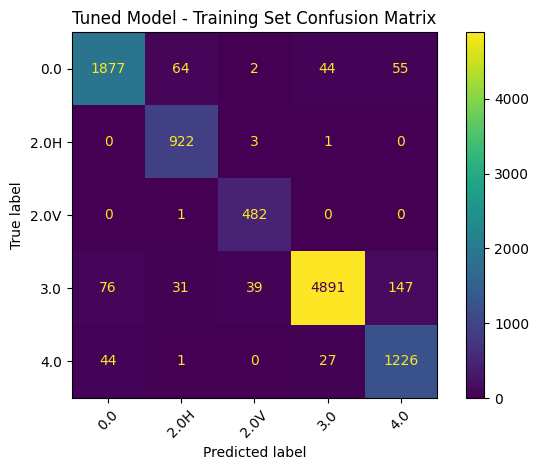


Performance when gear is stable
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95      1675
        2.0H       0.91      1.00      0.95       788
        2.0V       0.94      1.00      0.97       396
         3.0       0.99      0.97      0.98      4625
         4.0       0.88      0.97      0.92       933

    accuracy                           0.96      8417
   macro avg       0.94      0.97      0.96      8417
weighted avg       0.97      0.96      0.96      8417



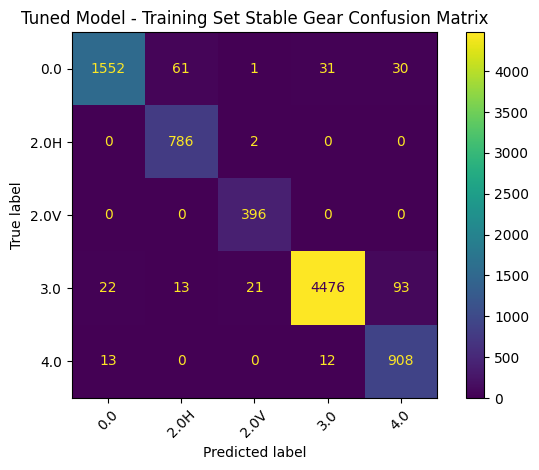


TUNED MODEL - Test Performance
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.82       328
        2.0H       0.92      0.90      0.91       385
        2.0V       0.00      0.00      0.00         0
         3.0       0.92      0.92      0.92      1208
         4.0       0.65      0.61      0.63       297

    accuracy                           0.86      2218
   macro avg       0.66      0.65      0.66      2218
weighted avg       0.87      0.86      0.87      2218




C:\Users\canoe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\canoe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\canoe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: Unde

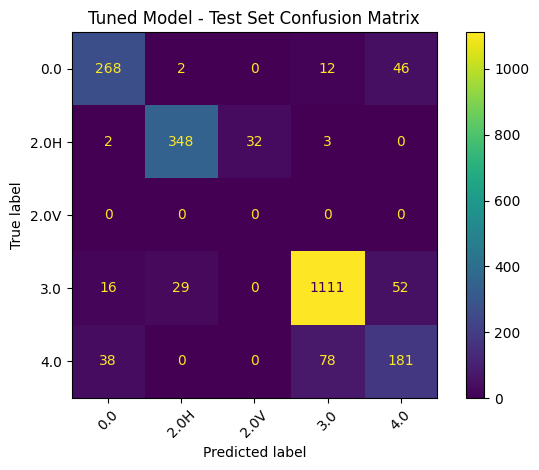


Performance when gear is stable
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90       248
        2.0H       0.98      0.91      0.94       345
        2.0V       0.00      0.00      0.00         0
         3.0       0.95      0.96      0.95      1092
         4.0       0.74      0.69      0.71       207

    accuracy                           0.91      1892
   macro avg       0.71      0.69      0.70      1892
weighted avg       0.93      0.91      0.92      1892



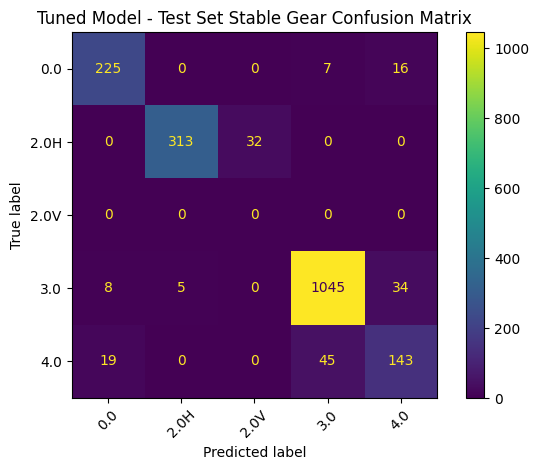

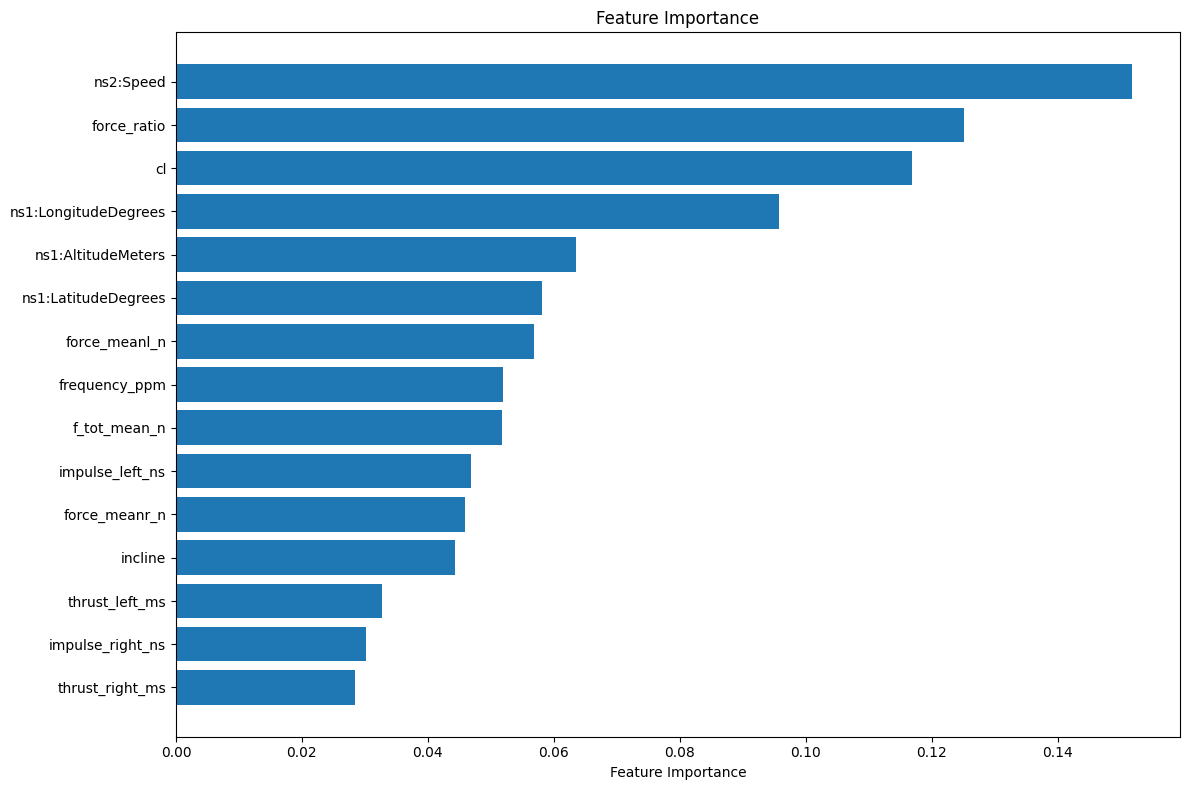


Top 10 most important features:
                 feature  importance
9              ns2:Speed    0.151828
12           force_ratio    0.125060
13                    cl    0.116839
11  ns1:LongitudeDegrees    0.095743
8     ns1:AltitudeMeters    0.063491
10   ns1:LatitudeDegrees    0.058191
5          force_meanl_n    0.056895
0          frequency_ppm    0.051859
7           f_tot_mean_n    0.051769
3        impulse_left_ns    0.046894


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

pd.options.display.max_columns = 120



# classify all as gear 0 if freq = 0 before passing on to random forest?


def load_data(file_path):
    """Load data from a CSV file into a pandas DataFrame."""
    return pd.read_csv(file_path)


train_dir = Path(r"C:\Users\canoe\OneDrive\Asztali gép\Chalmers - Subtech classifier\processed data with gear\nr")                     # could not find the 'Training and validation set' nor the 'Test_set'
train_files = list(train_dir.glob("*.csv"))
print(f"Training files: {len(train_files)}")

test_dir = Path(r"C:\Users\canoe\OneDrive\Asztali gép\Chalmers - Subtech classifier\processed data with gear\test set_nr")
test_files = list(test_dir.glob("*.csv"))
print(f"Test files: {len(test_files)}") 



history = 10
lag = 5
output_col = "Gear"

#cleaned the feature variables
info_columns = ['tt_s', 'Lap', 'Gear', 'Sport'] 
feature_columns_pole_data = ['frequency_ppm', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n']
feature_columns_gnss = ['ns1:AltitudeMeters', 'ns2:Speed', 'ns1:LatitudeDegrees', 'ns1:LongitudeDegrees']



feature_columns = feature_columns_pole_data + feature_columns_gnss


dfs = [load_data(file) for file in train_files]
test_dfs = [load_data(file) for file in test_files]

def make_sure_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

dfs = [make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data) for df in dfs]
test_dfs = [make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data) for df in test_dfs]



#defined function for calculating incline
def incline(df):
    dist = df['ns1:DistanceMeters3'].to_numpy()
    alt = df['ns1:AltitudeMeters'].to_numpy()

    dist_diff = np.diff(dist)
    alt_diff = np.diff(alt)

    incline = np.empty_like(dist, dtype=float)
    incline[:] = np.nan 

    mask = dist_diff != 0
    incline[1:][mask] = np.degrees(np.arctan(alt_diff[mask] / dist_diff[mask]))

    df["incline"] = incline
    return df



def add_ratios(df):
    df = df.copy()
    df["force_ratio"] = df["force_meanl_n"]/(df["force_meanl_n"] + df["force_meanr_n"] + 1e-6)
    df["thrust_ratio"] = df["thrust_left_ms"]/(df["thrust_left_ms"] + df["thrust_right_ms"] + 1e-6)
    df["impulse_ratio"] = df["impulse_left_ns"]/(df["impulse_left_ns"] + df["impulse_right_ns"] + 1e-6)
    df["cl"] = df['ns2:Speed'] / (df['frequency_ppm'] / 60 + 1e-6)

    return df



dfs = [incline(df) for df in dfs]
test_dfs = [incline(df) for df in test_dfs]

dfs = [add_ratios(df) for df in dfs]
test_dfs = [add_ratios(df) for df in test_dfs]


#define used features here, and not below
feature_columns = feature_columns_pole_data + feature_columns_gnss + ['force_ratio', 'cl', 'incline']



def create_lagged_features(df, feature_cols, history, lag):
    df = df.copy()
    new_cols = {}

    # Lagged features
    for h in range(1, lag + 1):
        for col in feature_cols:
            new_cols[f"{col}_lag{h}"] = df[col].shift(h)

    # Rolling mean and std
    for h in range(history):
        for col in feature_cols:
            rolling = df[col].shift(h).rolling(window=lag)
            new_cols[f"{col}_mean_lag{h}"] = rolling.mean()
            new_cols[f"{col}_std_lag{h}"] = rolling.std()

    df_new = pd.DataFrame(new_cols, index=df.index)
    df = pd.concat([df, df_new], axis=1)
    
    # Only drop rows where target is missing
    df = df.dropna(subset=["Gear"]).reset_index(drop=True)
    return df




dfs = [create_lagged_features(df, feature_columns, history, lag) for df in dfs]
test_dfs = [create_lagged_features(df, feature_columns, history, lag) for df in test_dfs]






def _stable_indices(y, n=2):
    """Return positional indices where the label has been stable for n before and n after."""
    y = y.reset_index(drop=True)
    idx = []
    for i in range(n, len(y) - n):
        c = y.iloc[i]
        # use iloc for positional comparisons
        if all(y.iloc[i - j] == c and y.iloc[i + j] == c for j in range(1, n + 1)):
            idx.append(i)
    return idx

def accuracy_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return np.nan
    return np.mean(y.iloc[idx].values == pred[idx])

def classification_report_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return "No stable segments found."
    return classification_report(y.iloc[idx], pred[idx], labels=ALL_LABELS, zero_division=0)

def confusion_matrix_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return None
    return confusion_matrix(y.iloc[idx], pred[idx], labels=ALL_LABELS)



train_df = pd.concat(dfs, ignore_index=True)
print(f"Training data shape: {train_df.shape}")
test_df = pd.concat(test_dfs, ignore_index=True)
print(f"Test data shape: {test_df.shape}")



#TO TAKE AWAY GEAR 0

#non_zero_dfs = [df[df['frequency_ppm'] != 0].copy() for df in dfs]

#non_zero_testdfs = [df[df['frequency_ppm'] != 0].copy() for df in test_dfs]


#train_df = pd.concat(non_zero_dfs, ignore_index=True)
#print(f"Training data shape: {train_df.shape}")
#test_df = pd.concat(non_zero_testdfs, ignore_index=True)
#print(f"Test data shape: {test_df.shape}")




def XY(df, feature_columns):
    X = df[feature_columns]
    Y = df[output_col]
    return X, Y



X_train, y_train = XY(train_df, feature_columns)
X_test, y_test = XY(test_df, feature_columns)


ALL_LABELS = sorted(y_train.unique())


rf_tuned = RandomForestClassifier(
    n_estimators=200,              # Tress
    max_depth=15,                  # Tree depth
    min_samples_split=10,          # Samples needed for a split
    min_samples_leaf=4,            # Samples needed for a leaf
    max_features='sqrt',           # Use sqrt(n_features) per split (adds randomness)
    class_weight='balanced',       # Keep this for class imbalance
    bootstrap=True,                # Enable bootstrapping
    oob_score=True,                # Get out-of-bag score (free validation estimate)
    n_jobs=-1,
    random_state=42
)


print("Training tuned Random Forest...")
rf_tuned.fit(X_train, y_train)
print(f"Out-of-bag score: {rf_tuned.oob_score_:.4f}")




pred_train = rf_tuned.predict(X_train)
pred_test = rf_tuned.predict(X_test)

print("\n" + "="*50)
print("TUNED MODEL - Training Performance")
print("="*50)
print(classification_report(y_train, pred_train))
# Confusion matrix
cm = confusion_matrix(y_train, pred_train, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Training Set Confusion Matrix")
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Performance when gear is stable")
print("="*50)
print(classification_report_when_stable_gear(y_train, pred_train))
# Confusion matrix
cm = confusion_matrix_when_stable_gear(y_train, pred_train)
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Training Set Stable Gear Confusion Matrix")
plt.tight_layout()
plt.show()


print("\n" + "="*50)
print("TUNED MODEL - Test Performance")
print("="*50)
print(classification_report(y_test, pred_test))
print("\n" + "="*50)
# Confusion matrix
cm = confusion_matrix(y_test, pred_test, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Test Set Confusion Matrix")
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Performance when gear is stable")
print("="*50)
print(classification_report_when_stable_gear(y_test, pred_test))
# Confusion matrix
cm = confusion_matrix_when_stable_gear(y_test, pred_test)
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Test Set Stable Gear Confusion Matrix")
plt.tight_layout()
plt.show()



feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_tuned.feature_importances_
}).sort_values('importance', ascending=False)


plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importance.head(10))


Training files: 9
Test files: 2
Training data shape: (9933, 452)
Test data shape: (2218, 447)
Training data shape: (7271, 452)
Test data shape: (1799, 447)
Training tuned Random Forest...
Out-of-bag score: 0.8753

TUNED MODEL - Training Performance
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92       608
        2.0H       0.96      0.99      0.98       919
        2.0V       0.93      1.00      0.96       468
         3.0       1.00      0.95      0.97      4453
         4.0       0.89      0.99      0.94       823

    accuracy                           0.96      7271
   macro avg       0.93      0.98      0.95      7271
weighted avg       0.97      0.96      0.96      7271



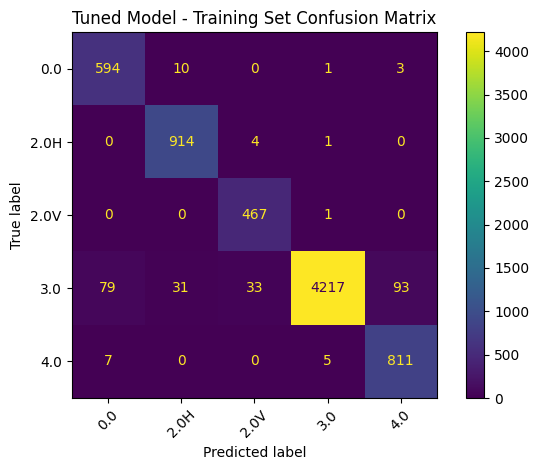


Performance when gear is stable
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93       408
        2.0H       0.97      1.00      0.98       784
        2.0V       0.95      1.00      0.98       391
         3.0       1.00      0.97      0.98      3950
         4.0       0.94      1.00      0.97       571

    accuracy                           0.98      6104
   macro avg       0.95      0.99      0.97      6104
weighted avg       0.98      0.98      0.98      6104



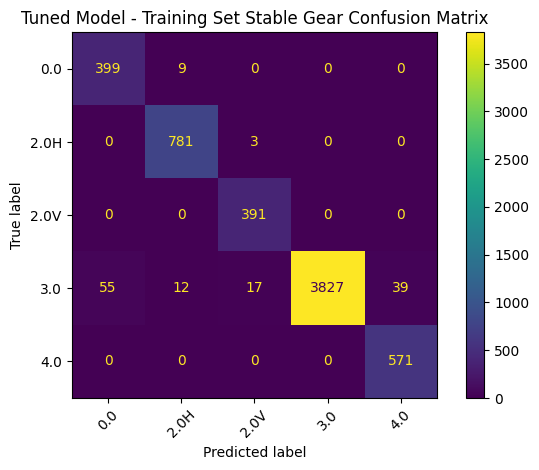


TUNED MODEL - Test Performance
              precision    recall  f1-score   support

         0.0       0.44      0.63      0.52        63
        2.0H       0.94      0.88      0.91       385
        2.0V       0.00      0.00      0.00         0
         3.0       0.94      0.95      0.94      1119
         4.0       0.77      0.62      0.69       232

    accuracy                           0.88      1799
   macro avg       0.62      0.62      0.61      1799
weighted avg       0.90      0.88      0.89      1799




C:\Users\canoe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\canoe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\canoe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: Unde

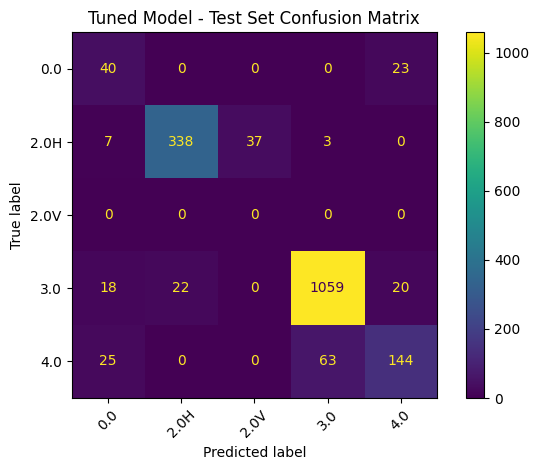


Performance when gear is stable
              precision    recall  f1-score   support

         0.0       0.27      0.44      0.33        18
        2.0H       0.99      0.89      0.94       345
        2.0V       0.00      0.00      0.00         0
         3.0       0.97      0.98      0.97      1003
         4.0       0.86      0.74      0.80       166

    accuracy                           0.93      1532
   macro avg       0.62      0.61      0.61      1532
weighted avg       0.95      0.93      0.94      1532



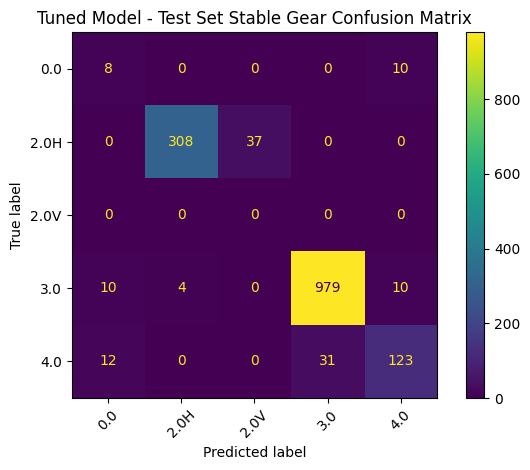

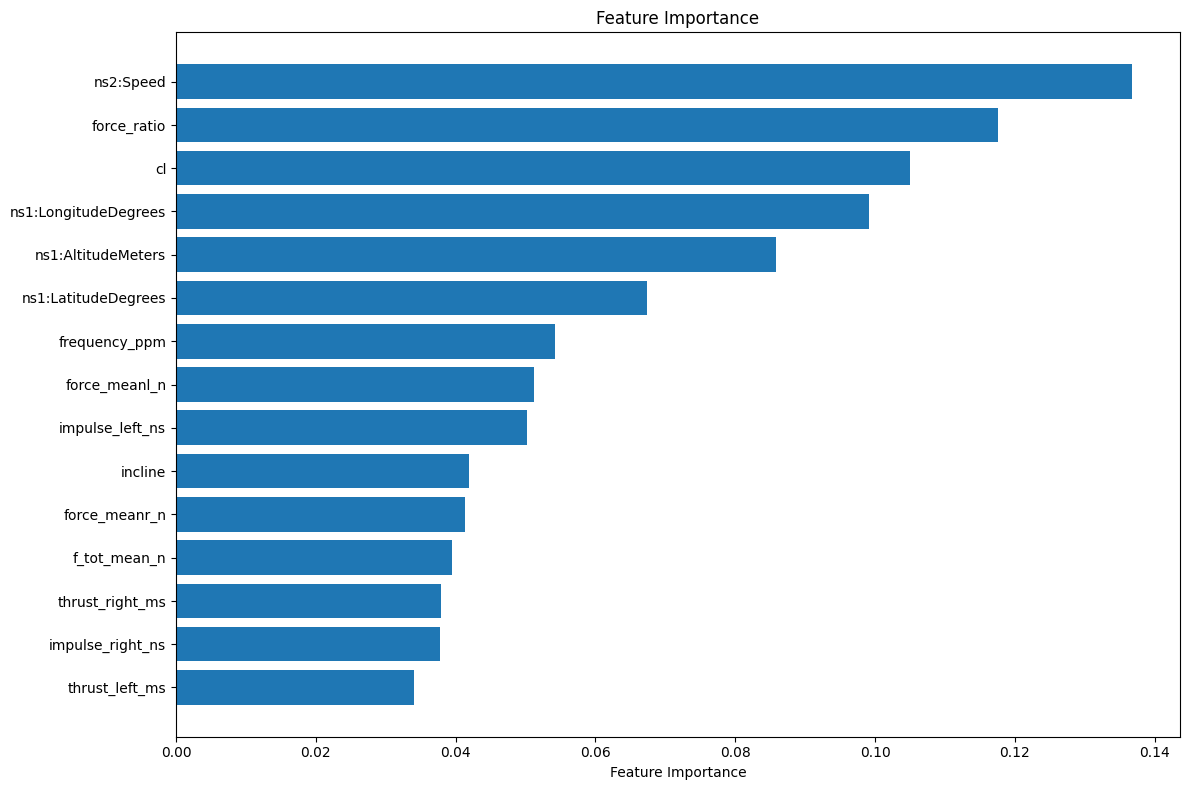


Top 10 most important features:
                 feature  importance
9              ns2:Speed    0.136782
12           force_ratio    0.117575
13                    cl    0.105020
11  ns1:LongitudeDegrees    0.099141
8     ns1:AltitudeMeters    0.085803
10   ns1:LatitudeDegrees    0.067394
0          frequency_ppm    0.054278
5          force_meanl_n    0.051254
3        impulse_left_ns    0.050162
14               incline    0.041949


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

pd.options.display.max_columns = 120



# classify all as gear 0 if freq = 0 before passing on to random forest?


def load_data(file_path):
    """Load data from a CSV file into a pandas DataFrame."""
    return pd.read_csv(file_path)


train_dir = Path(r"C:\Users\canoe\OneDrive\Asztali gép\Chalmers - Subtech classifier\processed data with gear\nr")                     # could not find the 'Training and validation set' nor the 'Test_set'
train_files = list(train_dir.glob("*.csv"))
print(f"Training files: {len(train_files)}")

test_dir = Path(r"C:\Users\canoe\OneDrive\Asztali gép\Chalmers - Subtech classifier\processed data with gear\test set_nr")
test_files = list(test_dir.glob("*.csv"))
print(f"Test files: {len(test_files)}") 



history = 10
lag = 5
output_col = "Gear"

#cleaned the feature variables
info_columns = ['tt_s', 'Lap', 'Gear', 'Sport'] 
feature_columns_pole_data = ['frequency_ppm', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n']
feature_columns_gnss = ['ns1:AltitudeMeters', 'ns2:Speed', 'ns1:LatitudeDegrees', 'ns1:LongitudeDegrees']



feature_columns = feature_columns_pole_data + feature_columns_gnss


dfs = [load_data(file) for file in train_files]
test_dfs = [load_data(file) for file in test_files]

def make_sure_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

dfs = [make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data) for df in dfs]
test_dfs = [make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data) for df in test_dfs]



#defined function for calculating incline
def incline(df):
    dist = df['ns1:DistanceMeters3'].to_numpy()
    alt = df['ns1:AltitudeMeters'].to_numpy()

    dist_diff = np.diff(dist)
    alt_diff = np.diff(alt)

    incline = np.empty_like(dist, dtype=float)
    incline[:] = np.nan 

    mask = dist_diff != 0
    incline[1:][mask] = np.degrees(np.arctan(alt_diff[mask] / dist_diff[mask]))

    df["incline"] = incline
    return df



def add_ratios(df):
    df = df.copy()
    df["force_ratio"] = df["force_meanl_n"]/(df["force_meanl_n"] + df["force_meanr_n"] + 1e-6)
    df["thrust_ratio"] = df["thrust_left_ms"]/(df["thrust_left_ms"] + df["thrust_right_ms"] + 1e-6)
    df["impulse_ratio"] = df["impulse_left_ns"]/(df["impulse_left_ns"] + df["impulse_right_ns"] + 1e-6)
    df["cl"] = df['ns2:Speed'] / (df['frequency_ppm'] / 60 + 1e-6)

    return df



dfs = [incline(df) for df in dfs]
test_dfs = [incline(df) for df in test_dfs]

dfs = [add_ratios(df) for df in dfs]
test_dfs = [add_ratios(df) for df in test_dfs]


#define used features here, and not below
feature_columns = feature_columns_pole_data + feature_columns_gnss + ['force_ratio', 'cl', 'incline']



def create_lagged_features(df, feature_cols, history, lag):
    df = df.copy()
    new_cols = {}

    # Lagged features
    for h in range(1, lag + 1):
        for col in feature_cols:
            new_cols[f"{col}_lag{h}"] = df[col].shift(h)

    # Rolling mean and std
    for h in range(history):
        for col in feature_cols:
            rolling = df[col].shift(h).rolling(window=lag)
            new_cols[f"{col}_mean_lag{h}"] = rolling.mean()
            new_cols[f"{col}_std_lag{h}"] = rolling.std()

    df_new = pd.DataFrame(new_cols, index=df.index)
    df = pd.concat([df, df_new], axis=1)
    
    # Only drop rows where target is missing
    df = df.dropna(subset=["Gear"]).reset_index(drop=True)
    return df




dfs = [create_lagged_features(df, feature_columns, history, lag) for df in dfs]
test_dfs = [create_lagged_features(df, feature_columns, history, lag) for df in test_dfs]






def _stable_indices(y, n=2):
    """Return positional indices where the label has been stable for n before and n after."""
    y = y.reset_index(drop=True)
    idx = []
    for i in range(n, len(y) - n):
        c = y.iloc[i]
        # use iloc for positional comparisons
        if all(y.iloc[i - j] == c and y.iloc[i + j] == c for j in range(1, n + 1)):
            idx.append(i)
    return idx

def accuracy_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return np.nan
    return np.mean(y.iloc[idx].values == pred[idx])

def classification_report_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return "No stable segments found."
    return classification_report(y.iloc[idx], pred[idx], labels=ALL_LABELS, zero_division=0)

def confusion_matrix_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return None
    return confusion_matrix(y.iloc[idx], pred[idx], labels=ALL_LABELS)



train_df = pd.concat(dfs, ignore_index=True)
print(f"Training data shape: {train_df.shape}")
test_df = pd.concat(test_dfs, ignore_index=True)
print(f"Test data shape: {test_df.shape}")



#TO TAKE AWAY GEAR 0

non_zero_dfs = [df[df['frequency_ppm'] > 20].copy() for df in dfs]

non_zero_testdfs = [df[df['frequency_ppm'] > 20].copy() for df in test_dfs]


train_df = pd.concat(non_zero_dfs, ignore_index=True)
print(f"Training data shape: {train_df.shape}")
test_df = pd.concat(non_zero_testdfs, ignore_index=True)
print(f"Test data shape: {test_df.shape}")




def XY(df, feature_columns):
    X = df[feature_columns]
    Y = df[output_col]
    return X, Y



X_train, y_train = XY(train_df, feature_columns)
X_test, y_test = XY(test_df, feature_columns)


ALL_LABELS = sorted(y_train.unique())


rf_tuned = RandomForestClassifier(
    n_estimators=200,              # Tress
    max_depth=15,                  # Tree depth
    min_samples_split=10,          # Samples needed for a split
    min_samples_leaf=4,            # Samples needed for a leaf
    max_features='sqrt',           # Use sqrt(n_features) per split (adds randomness)
    class_weight='balanced',       # Keep this for class imbalance
    bootstrap=True,                # Enable bootstrapping
    oob_score=True,                # Get out-of-bag score (free validation estimate)
    n_jobs=-1,
    random_state=42
)


print("Training tuned Random Forest...")
rf_tuned.fit(X_train, y_train)
print(f"Out-of-bag score: {rf_tuned.oob_score_:.4f}")




pred_train = rf_tuned.predict(X_train)
pred_test = rf_tuned.predict(X_test)

print("\n" + "="*50)
print("TUNED MODEL - Training Performance")
print("="*50)
print(classification_report(y_train, pred_train))
# Confusion matrix
cm = confusion_matrix(y_train, pred_train, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Training Set Confusion Matrix")
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Performance when gear is stable")
print("="*50)
print(classification_report_when_stable_gear(y_train, pred_train))
# Confusion matrix
cm = confusion_matrix_when_stable_gear(y_train, pred_train)
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Training Set Stable Gear Confusion Matrix")
plt.tight_layout()
plt.show()


print("\n" + "="*50)
print("TUNED MODEL - Test Performance")
print("="*50)
print(classification_report(y_test, pred_test))
print("\n" + "="*50)
# Confusion matrix
cm = confusion_matrix(y_test, pred_test, labels=sorted(y_train.unique()))
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Test Set Confusion Matrix")
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Performance when gear is stable")
print("="*50)
print(classification_report_when_stable_gear(y_test, pred_test))
# Confusion matrix
cm = confusion_matrix_when_stable_gear(y_test, pred_test)
ConfusionMatrixDisplay(cm, display_labels=ALL_LABELS).plot(xticks_rotation=45)
plt.title("Tuned Model - Test Set Stable Gear Confusion Matrix")
plt.tight_layout()
plt.show()



feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_tuned.feature_importances_
}).sort_values('importance', ascending=False)


plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importance.head(10))
